# AM207 Final Project

Paper: *Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks*

207Notes:
 -  reproduce figure 6 (rows are random restarts, see main paper) with NLM 2 hidden layers 50-50
 -  new code: plot the priors
 -  verify in paper, how many iterations were done for this figure, verify data generating process
 - 
 -  

In [8]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

#config
from config import *

### Generate Data

In [9]:

# training data
x_train, y_train, x_test = utils.generate_data()

# for model evaluation: computing log likelihood
x_valid, y_valid, x_test_not_used = utils.generate_data()



### Run Vanilla Nueral Network

 Iteration 0 lower bound 458575.4794849707; gradient mag: 1326119.3109850362
 0.225 Seconds, Log Likilihood 2252.0013514424154


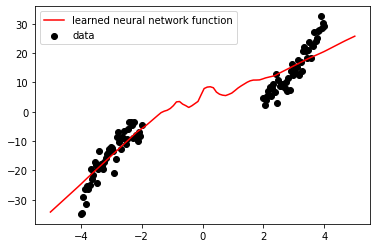

In [10]:
nn = Feedforward(nlm_architecture, random=random_seed)

t0 = time.time()
nn.fit(x_train, y_train, opt_params)
nn_time = np.round(time.time() - t0, 3)

mse = nn.objective_trace.min()

print(f"\n {nn_time} Seconds, Log Likilihood {mse}")

#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)

#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()


### NLM Demo

In [11]:
# test
test_nlm = NLM(prior_variance,
               y_noise_variance,
               regularization_param_nlm, 
               nlm_architecture, 
               random_state = random_seed)

In [12]:

t0 = time.time()
test_nlm.train(x_train,y_train, opt_params)
nlm_time = np.round(time.time() - t0, 3)
nlm_mse = test_nlm.ff.objective_trace.min()

print(f"{nlm_time} Seconds, {nlm_mse} MSE")

 Iteration 0 lower bound 4458.846293365392; gradient mag: 12178.808017760608
Done Training
0.242 Seconds, 482.6516964758533 MSE


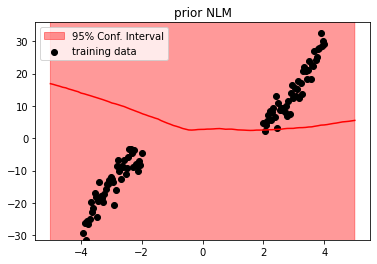

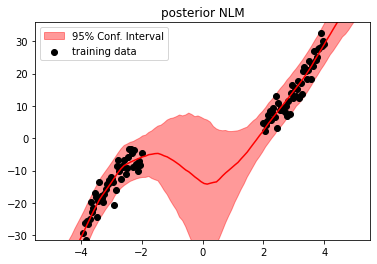

In [13]:
for predictive_name, boolean in {"prior NLM":True, "posterior NLM":False}.items():
    predictives, predictive_samples = test_nlm.predict(x_test,prior = boolean)
    bh.viz_pp_samples(x_train, y_train,x_test.flatten(),predictive_samples,predictive_name)

In [14]:
from autograd import scipy as sp
import math
        
test_nlm.get_log_l(x_train,y_train,x_valid,y_valid)

-123.14832590731037

## testing log likilihood

In [15]:
# we should VERIFY that log likelihood at 5000 is greater than 1000
i_params = params.copy()
for i in [10,100,200,300,400,1000]:
    i_params['max_iteration'] = i
    test_nlm.train(x_train,y_train, i_params)
    print(test_nlm.get_log_l(x_train,y_train,x_valid,y_valid))

 Iteration 0 lower bound 482.6516964758533; gradient mag: 143.8984642954146
Done Training
-123.53127881329807
 Iteration 0 lower bound 469.01240357742745; gradient mag: 75.86740599808891
Done Training
-123.64823991756768
 Iteration 100 lower bound 371.2961394660106; gradient mag: 8.546951338445846
Done Training
-123.76314288264739
 Iteration 200 lower bound 299.6827703853644; gradient mag: 8.373979664098192
Done Training
-124.52644110633977
 Iteration 300 lower bound 215.6430567322612; gradient mag: 8.1979143038517348
Done Training
-125.75746236387722
 Iteration 900 lower bound 86.51943130341274; gradient mag: 6.2223204190777059
Done Training
-131.36979466022714


In [16]:
# looks good
print(params['max_iteration'])
i_architecture = architecture.copy()
for i in [1,2,5,10,50]:
    print(f"\n width: {i}")
    i_architecture['width'] = i
    test_nlm_i = NLM(prior_var,y_var, regularization_param_nlm,i_architecture, random_state = np.random.RandomState(0))
    test_nlm_i.train(x_train,y_train, params)
    print(test_nlm_i.get_log_l(x_train,y_train,x_valid,y_valid))

500

 width: 1
 Iteration 400 lower bound 217.83009972640653; gradient mag: 38.799030515941354
Done Training
-682.5027762384344

 width: 2
 Iteration 400 lower bound 200.65451210095284; gradient mag: 18.507307170376944
Done Training
-1201.1237660782629

 width: 5
 Iteration 400 lower bound 130.0518772469028; gradient mag: 38.0323284271036145
Done Training
-752.3783710541819

 width: 10
 Iteration 400 lower bound 176.83193577443873; gradient mag: 207.90618469443514
Done Training
-634.8172569074133

 width: 50
 Iteration 400 lower bound 379.19108342316355; gradient mag: 25.02237914983933
Done Training
-296.6248465508823
